

# Image Segmenation using superpixels
The goal is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite oepn-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 

Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

In [ ]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2020-12-17 00:24:23--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.43.252.222, 2600:1408:3000:28b::e59, 2600:1408:3000:294::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.43.252.222|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M   191MB/s    in 0.2s    

2020-12-17 00:24:23 (191 MB/s) - ‘msrc_objcategimagedatabase_v1.zip’ saved [44119839/44119839]



In [ ]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return     

## Step 1: 
First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package. You are welcome to compare your own SLIC Superpixels output from assignment 1 with scikit-image SLIC output. But we would be grading the outputs in comparison to the scikit-image superpixel outputs. 

However, before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

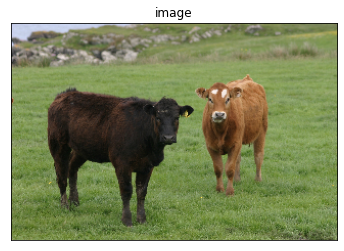

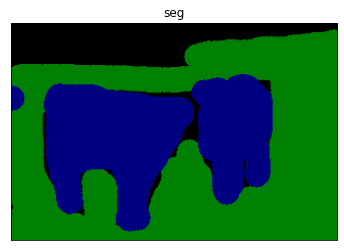

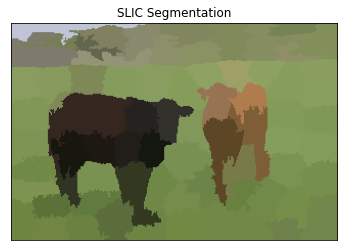

In [ ]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [ ]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os

from tqdm import tqdm
import pandas as pd

current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

In [ ]:
## Create the train, test directories

def make_dir(directory):
  dir_path = os.path.join(msrc_directory, directory)
  if not os.path.exists(dir_path):
    os.mkdir(dir_path)
  return dir_path


datasets_dir = 'datasets'
train_dir = 'datasets/train'
test_dir = 'datasets/test'
datasets_path = os.path.join(msrc_directory, datasets_dir)
if not os.path.exists(datasets_path):
  os.mkdir(datasets_path)


datasets_path = make_dir(datasets_dir)
train_path = make_dir(train_dir)
test_path = make_dir(test_dir)

In [ ]:
#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
label_2_rgb = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']
    label_2_rgb[i['id']] = i['rgb_values']



Suggested algorithm: Save the superpixels along with their segmentation class

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Also Suggested would be creating a single csv with columns segment patch location, class label for each sp_i of each image.<br>




In [ ]:
#from IPython.display import Image
#Image(filename='data_preprocessing.png') 

In [ ]:
## All the global constants:

#Image pre-processing
GT = '_GT'
BMP_EXT = '.bmp'
NPY = '.npy'
NUM_SLIC_SEG = 100

#train and test files
TRAIN_DIR = 'train'
TEST_DIR = 'test'
TRAIN_TEXTFILE = 'train.txt'
TEST_TEXTFILE = 'test.txt'

TRAIN_CSVFILE = 'train.csv'
TEST_CSVFILE = 'test.csv'

NUM_WORKERS = 2

# data transformers
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


# hyperparams
NUM_EPOCH = 5
BATCH_SIZE = 16
LEARNING_RATE = 1e-4


In [ ]:
def get_rect_patch(index_list):
  y_list = index_list[0]
  x_list = index_list[1]
  x_min, x_max = min(x_list), max(x_list)
  y_min, y_max = min(y_list), max(y_list)
  return x_min, x_max, y_min, y_max


def dilate_rect_patch(rect_patch_loc, H, W, num_pix=3):
  x_min, x_max, y_min, y_max = rect_patch_loc
  
  x_min = max(0, x_min - num_pix)
  y_min = max(0, y_min - num_pix)

  x_max = min(W, x_max + num_pix)
  y_max = max(H, y_max + num_pix)

  return x_min, x_max, y_min, y_max


def get_rect_patch_loc(seg_map, seg_label):
  H, W = seg_map.shape
  seg_label_ind = np.where(seg_map == seg_label)
  if len(seg_label_ind[0]) == 0:
    return None

  rect_patch_loc = get_rect_patch(seg_label_ind)

  ## dilate the superpixel / rectangle
  rect_patch_loc = dilate_rect_patch(rect_patch_loc, H, W)
  return rect_patch_loc


def crop_image(image, rect_patch_loc):
  x_min, x_max, y_min, y_max = rect_patch_loc
  cropped_image = image[y_min:y_max, x_min:x_max, :]
  return cropped_image

def get_gt_seg_class(gt_image_patch):
  label_count_map = np.zeros(10)
  ht, wd = gt_image_patch.shape[:-1]
  for i in range(ht):
    for j in range(wd):
      color = tuple(gt_image_patch[i,j])
      label = rgb_2_label.get(color, -1) # void label if color key not found
      label_count_map[label+1] += 1  #label_count_map.get(label, 0) + 1   
  
  seg_class = np.argmax(label_count_map)
  
  '''
  max_count = 0
  seg_class = -1
  for label in label_count_map:
    count = label_count_map[label]
    if count > max_count:
      max_count = count
      seg_class = label
  '''

  return (seg_class)   # Pytorch not working with negative labels so incrementing them by one. 



def crop_patches_and_save(seg_map, sample_image, gt_image, im_filename, data_path, csv_objects, text_file):
  for label in range(NUM_SLIC_SEG):
    rect_patch_loc = get_rect_patch_loc(seg_map, label)
    if rect_patch_loc is not None:
      sample_im_cropped = crop_image(sample_image, rect_patch_loc)
      gt_im_cropped = crop_image(gt_image, rect_patch_loc)
      seg_class_label = get_gt_seg_class(gt_im_cropped)
      
      # now we can save the train_image and the class label
      data_filename = im_filename.replace(BMP_EXT, (f'_{label}_{NPY}'))
      data_filename_path = f'{data_path}/{data_filename}'
      
      np.save(data_filename_path, sample_im_cropped)
      
      csv_objects.append([data_filename, seg_class_label])
      
      with open(f'{datasets_path}/{text_file}', 'a+') as textfile:
        textfile.write(data_filename + '\n')




In [ ]:

# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.



#if os.path.exists('./datasets/train.txt'):
#    os.remove('./datasets/train.txt')

list_files = os.listdir(msrc_directory)
total_images = len(list_files)
TRAIN_SIZE = int(len(list_files) * 0.8)
TEST_SIZE = total_images - TRAIN_SIZE

training_files = list_files[:TRAIN_SIZE]
testing_files = list_files[TRAIN_SIZE:]

# Your code
def prepare_data(list_filenames, data_path, csv_file, textfile_to_save):
  csv_objects = []  # [image_file_path, label]
  for filename in tqdm(list_filenames, leave=False):
    # Your code
    if BMP_EXT in filename and GT not in filename:
      print(filename)
      sample_filename = filename
      gt_filename = filename.replace(BMP_EXT, (GT+BMP_EXT))
      
      sample_filename = os.path.join(msrc_directory, sample_filename)
      gt_filename = os.path.join(msrc_directory, gt_filename)

      sample_image = cv2.imread(sample_filename)
      gt_image = cv2.imread(gt_filename)
      
      sample_image = sample_image[:,:,::-1]   # bgr to rgb
      gt_image = gt_image[:,:,::-1]           # bgr to rgb

      seg_map = slic(sample_image, n_segments=NUM_SLIC_SEG, compactness=10)
      crop_patches_and_save(seg_map, sample_image, gt_image, filename, data_path, csv_objects, textfile_to_save)
      
  
  # create csv file:
  imagepath_label = pd.DataFrame(csv_objects, columns=['image_path', 'label'])
  imagepath_label.to_csv(f'{data_path}/{csv_file}')



prepare_data(training_files, train_path, TRAIN_CSVFILE, TRAIN_TEXTFILE)
print('Finished processing training data')

prepare_data(testing_files, test_path, TEST_CSVFILE, TEST_TEXTFILE)
print('Finished processing testing data')



  0%|          | 0/386 [00:00<?, ?it/s]

1_23_s.bmp



  1%|          | 3/386 [00:02<05:18,  1.20it/s]

7_27_s.bmp



  2%|▏         | 8/386 [00:05<04:48,  1.31it/s]

4_27_s.bmp



  2%|▏         | 9/386 [00:08<09:34,  1.52s/it]

2_7_s.bmp



  3%|▎         | 12/386 [00:11<08:07,  1.30s/it]

3_4_s.bmp



  4%|▎         | 14/386 [00:13<08:07,  1.31s/it]

4_19_s.bmp



  4%|▍         | 16/386 [00:16<08:26,  1.37s/it]

6_20_s.bmp



  5%|▍         | 19/386 [00:19<07:44,  1.26s/it]

2_12_s.bmp



  6%|▌         | 24/386 [00:21<05:58,  1.01it/s]

6_8_s.bmp



  7%|▋         | 27/386 [00:24<06:02,  1.01s/it]

1_25_s.bmp



  7%|▋         | 28/386 [00:27<09:23,  1.57s/it]

3_14_s.bmp



  8%|▊         | 29/386 [00:30<12:02,  2.02s/it]

2_6_s.bmp



  8%|▊         | 30/386 [00:33<13:42,  2.31s/it]

8_24_s.bmp



  8%|▊         | 31/386 [00:36<14:18,  2.42s/it]

2_10_s.bmp



  8%|▊         | 32/386 [00:38<13:33,  2.30s/it]

1_28_s.bmp



  9%|▊         | 33/386 [00:40<13:42,  2.33s/it]

1_16_s.bmp



  9%|▉         | 34/386 [00:44<15:36,  2.66s/it]

7_14_s.bmp



  9%|▉         | 35/386 [00:47<17:06,  2.92s/it]

6_5_s.bmp



 10%|█         | 40/386 [00:50<12:47,  2.22s/it]

6_12_s.bmp



 11%|█         | 42/386 [00:53<11:21,  1.98s/it]

6_11_s.bmp



 11%|█         | 43/386 [00:56<12:52,  2.25s/it]

1_7_s.bmp



 11%|█▏        | 44/386 [00:59<13:58,  2.45s/it]

4_2_s.bmp



 12%|█▏        | 45/386 [01:02<14:29,  2.55s/it]

6_15_s.bmp



 12%|█▏        | 48/386 [01:04<11:25,  2.03s/it]

7_26_s.bmp



 13%|█▎        | 50/386 [01:07<10:40,  1.91s/it]

1_3_s.bmp



 13%|█▎        | 51/386 [01:09<10:42,  1.92s/it]

2_13_s.bmp



 14%|█▍        | 54/386 [01:13<09:13,  1.67s/it]

3_10_s.bmp



 14%|█▍        | 55/386 [01:15<10:42,  1.94s/it]

1_29_s.bmp



 15%|█▍        | 57/386 [01:18<09:28,  1.73s/it]

3_5_s.bmp



 15%|█▌        | 59/386 [01:20<08:36,  1.58s/it]

8_19_s.bmp



 16%|█▌        | 60/386 [01:22<09:03,  1.67s/it]

4_9_s.bmp



 16%|█▌        | 62/386 [01:25<08:49,  1.63s/it]

3_18_s.bmp



 17%|█▋        | 65/386 [01:28<07:32,  1.41s/it]

7_21_s.bmp



 17%|█▋        | 66/386 [01:31<10:05,  1.89s/it]

5_30_s.bmp



 18%|█▊        | 68/386 [01:33<09:03,  1.71s/it]

1_12_s.bmp



 18%|█▊        | 69/386 [01:36<10:07,  1.92s/it]

2_15_s.bmp



 18%|█▊        | 71/386 [01:37<08:27,  1.61s/it]

6_29_s.bmp



 20%|█▉        | 76/386 [01:41<06:55,  1.34s/it]

5_27_s.bmp



 21%|██        | 81/386 [01:43<05:31,  1.09s/it]

2_8_s.bmp



 22%|██▏       | 83/386 [01:46<06:05,  1.20s/it]

7_20_s.bmp



 22%|██▏       | 84/386 [01:49<08:26,  1.68s/it]

7_15_s.bmp



 22%|██▏       | 86/386 [01:53<08:22,  1.68s/it]

1_17_s.bmp



 23%|██▎       | 88/386 [01:56<08:12,  1.65s/it]

8_1_s.bmp



 23%|██▎       | 89/386 [01:58<09:29,  1.92s/it]

4_3_s.bmp



 24%|██▎       | 91/386 [02:01<08:42,  1.77s/it]

7_29_s.bmp



 24%|██▍       | 94/386 [02:04<07:28,  1.54s/it]

7_16_s.bmp



 25%|██▌       | 98/386 [02:07<06:11,  1.29s/it]

5_22_s.bmp



 26%|██▌       | 99/386 [02:10<08:39,  1.81s/it]

6_14_s.bmp



 26%|██▌       | 101/386 [02:13<08:22,  1.76s/it]

3_26_s.bmp



 27%|██▋       | 103/386 [02:16<07:30,  1.59s/it]

7_23_s.bmp



 27%|██▋       | 104/386 [02:19<09:11,  1.96s/it]

6_19_s.bmp



 28%|██▊       | 110/386 [02:20<06:44,  1.47s/it]

7_4_s.bmp



 29%|██▉       | 111/386 [02:23<08:31,  1.86s/it]

1_20_s.bmp



 29%|██▉       | 112/386 [02:26<09:35,  2.10s/it]

1_26_s.bmp



 30%|██▉       | 114/386 [02:28<07:56,  1.75s/it]

5_5_s.bmp



 30%|███       | 116/386 [02:30<07:19,  1.63s/it]

4_5_s.bmp



 31%|███       | 119/386 [02:34<06:39,  1.50s/it]

7_10_s.bmp



 31%|███       | 120/386 [02:37<09:01,  2.04s/it]

4_24_s.bmp



 32%|███▏      | 123/386 [02:40<07:36,  1.74s/it]

1_30_s.bmp



 32%|███▏      | 124/386 [02:43<08:24,  1.92s/it]

5_12_s.bmp



 34%|███▎      | 130/386 [02:46<06:21,  1.49s/it]

6_10_s.bmp



 34%|███▍      | 131/386 [02:49<08:09,  1.92s/it]

3_17_s.bmp



 34%|███▍      | 132/386 [02:51<09:01,  2.13s/it]

4_8_s.bmp



 35%|███▍      | 135/386 [02:55<07:43,  1.85s/it]

6_24_s.bmp



 35%|███▌      | 136/386 [02:58<08:55,  2.14s/it]

4_20_s.bmp



 35%|███▌      | 137/386 [03:01<09:56,  2.40s/it]

8_25_s.bmp



 36%|███▌      | 138/386 [03:03<09:53,  2.39s/it]

2_29_s.bmp



 36%|███▌      | 139/386 [03:05<09:37,  2.34s/it]

5_17_s.bmp



 36%|███▋      | 140/386 [03:08<10:20,  2.52s/it]

6_22_s.bmp



 37%|███▋      | 141/386 [03:11<10:27,  2.56s/it]

8_14_s.bmp



 38%|███▊      | 145/386 [03:13<07:50,  1.95s/it]

3_15_s.bmp



 38%|███▊      | 146/386 [03:16<08:42,  2.18s/it]

2_21_s.bmp



 38%|███▊      | 147/386 [03:18<09:23,  2.36s/it]

7_6_s.bmp



 39%|███▉      | 150/386 [03:21<07:24,  1.88s/it]

6_3_s.bmp



 40%|████      | 155/386 [03:24<05:47,  1.50s/it]

7_1_s.bmp



 41%|████      | 157/386 [03:28<06:09,  1.61s/it]

1_8_s.bmp



 41%|████      | 159/386 [03:30<05:55,  1.56s/it]

4_17_s.bmp



 42%|████▏     | 161/386 [03:34<06:02,  1.61s/it]

3_16_s.bmp



 42%|████▏     | 162/386 [03:37<07:14,  1.94s/it]

2_9_s.bmp



 42%|████▏     | 163/386 [03:39<08:10,  2.20s/it]

7_18_s.bmp



 43%|████▎     | 165/386 [03:42<07:08,  1.94s/it]

7_22_s.bmp



 43%|████▎     | 166/386 [03:45<08:33,  2.33s/it]

5_29_s.bmp



 44%|████▍     | 170/386 [03:48<06:44,  1.87s/it]

1_5_s.bmp



 45%|████▍     | 172/386 [03:52<06:21,  1.78s/it]

3_25_s.bmp



 45%|████▍     | 173/386 [03:55<07:34,  2.13s/it]

1_21_s.bmp



 45%|████▌     | 175/386 [03:57<06:39,  1.89s/it]

2_1_s.bmp



 46%|████▌     | 177/386 [04:01<06:20,  1.82s/it]

4_14_s.bmp



 47%|████▋     | 180/386 [04:04<05:24,  1.58s/it]

8_3_s.bmp



 47%|████▋     | 182/386 [04:05<04:35,  1.35s/it]

6_4_s.bmp



 47%|████▋     | 183/386 [04:09<06:33,  1.94s/it]

4_4_s.bmp



 48%|████▊     | 184/386 [04:12<07:53,  2.34s/it]

1_19_s.bmp



 48%|████▊     | 185/386 [04:15<08:39,  2.59s/it]

1_14_s.bmp



 48%|████▊     | 186/386 [04:18<09:08,  2.74s/it]

3_30_s.bmp



 49%|████▉     | 189/386 [04:20<06:58,  2.13s/it]

3_13_s.bmp



 49%|████▉     | 191/386 [04:23<06:12,  1.91s/it]

8_22_s.bmp



 50%|████▉     | 192/386 [04:26<07:00,  2.17s/it]

3_8_s.bmp



 51%|█████     | 195/386 [04:28<05:26,  1.71s/it]

3_22_s.bmp



 51%|█████     | 196/386 [04:30<06:28,  2.05s/it]

8_18_s.bmp



 51%|█████     | 197/386 [04:33<07:02,  2.24s/it]

5_21_s.bmp



 52%|█████▏    | 202/386 [04:36<05:23,  1.76s/it]

3_9_s.bmp



 53%|█████▎    | 203/386 [04:39<06:12,  2.03s/it]

4_23_s.bmp



 53%|█████▎    | 206/386 [04:42<05:18,  1.77s/it]

2_4_s.bmp



 54%|█████▍    | 209/386 [04:45<04:30,  1.53s/it]

8_16_s.bmp



 54%|█████▍    | 210/386 [04:47<04:57,  1.69s/it]

5_23_s.bmp



 55%|█████▍    | 211/386 [04:50<06:02,  2.07s/it]

1_18_s.bmp



 55%|█████▍    | 212/386 [04:53<06:50,  2.36s/it]

3_11_s.bmp



 55%|█████▌    | 213/386 [04:56<07:20,  2.55s/it]

4_28_s.bmp



 56%|█████▌    | 215/386 [04:59<06:23,  2.24s/it]

5_2_s.bmp



 56%|█████▌    | 216/386 [05:03<07:07,  2.52s/it]

5_4_s.bmp



 57%|█████▋    | 221/386 [05:06<05:19,  1.93s/it]

3_12_s.bmp



 58%|█████▊    | 223/386 [05:09<04:57,  1.82s/it]

5_10_s.bmp



 58%|█████▊    | 225/386 [05:11<04:30,  1.68s/it]

5_24_s.bmp



 60%|█████▉    | 230/386 [05:14<03:31,  1.35s/it]

5_7_s.bmp



 61%|██████▏   | 237/386 [05:18<02:43,  1.10s/it]

6_9_s.bmp



 62%|██████▏   | 238/386 [05:21<04:04,  1.66s/it]

5_19_s.bmp



 62%|██████▏   | 239/386 [05:24<05:03,  2.07s/it]

7_17_s.bmp



 63%|██████▎   | 245/386 [05:27<03:45,  1.60s/it]

8_23_s.bmp



 64%|██████▎   | 246/386 [05:29<04:10,  1.79s/it]

8_12_s.bmp



 64%|██████▍   | 248/386 [05:32<04:01,  1.75s/it]

5_25_s.bmp



 65%|██████▍   | 249/386 [05:35<04:46,  2.09s/it]

4_6_s.bmp



 65%|██████▍   | 250/386 [05:38<05:15,  2.32s/it]

7_11_s.bmp



 66%|██████▌   | 254/386 [05:41<04:07,  1.88s/it]

2_20_s.bmp



 66%|██████▋   | 256/386 [05:45<03:56,  1.82s/it]

8_6_s.bmp



 67%|██████▋   | 257/386 [05:47<04:25,  2.06s/it]

1_4_s.bmp



 67%|██████▋   | 260/386 [05:49<03:27,  1.65s/it]

8_4_s.bmp



 68%|██████▊   | 263/386 [05:51<02:37,  1.28s/it]

7_2_s.bmp



 68%|██████▊   | 264/386 [05:54<03:38,  1.79s/it]

2_18_s.bmp



 69%|██████▉   | 266/386 [05:56<03:20,  1.67s/it]

2_19_s.bmp



 69%|██████▉   | 267/386 [05:59<03:54,  1.97s/it]

1_15_s.bmp



 69%|██████▉   | 268/386 [06:02<04:32,  2.31s/it]

3_29_s.bmp



 70%|██████▉   | 269/386 [06:05<04:43,  2.42s/it]

3_7_s.bmp



 70%|███████   | 272/386 [06:08<03:44,  1.97s/it]

2_14_s.bmp



 71%|███████   | 274/386 [06:11<03:33,  1.91s/it]

1_2_s.bmp



 71%|███████   | 275/386 [06:12<03:03,  1.65s/it]

7_24_s.bmp



 72%|███████▏  | 276/386 [06:16<03:54,  2.13s/it]

6_1_s.bmp



 72%|███████▏  | 278/386 [06:18<03:22,  1.88s/it]

4_29_s.bmp



 72%|███████▏  | 279/386 [06:22<04:14,  2.38s/it]

7_19_s.bmp



 73%|███████▎  | 283/386 [06:24<03:13,  1.88s/it]

6_13_s.bmp



 74%|███████▍  | 285/386 [06:28<02:59,  1.78s/it]

8_15_s.bmp



 74%|███████▍  | 286/386 [06:30<03:24,  2.05s/it]

5_26_s.bmp



 74%|███████▍  | 287/386 [06:33<03:53,  2.35s/it]

8_30_s.bmp



 75%|███████▍  | 288/386 [06:36<03:49,  2.35s/it]

1_22_s.bmp



 76%|███████▌  | 293/386 [06:38<02:47,  1.80s/it]

1_11_s.bmp



 76%|███████▌  | 294/386 [06:41<03:13,  2.10s/it]

4_22_s.bmp



 77%|███████▋  | 297/386 [06:44<02:39,  1.79s/it]

8_10_s.bmp



 77%|███████▋  | 299/386 [06:46<02:18,  1.59s/it]

3_24_s.bmp



 78%|███████▊  | 300/386 [06:50<02:54,  2.03s/it]

6_21_s.bmp



 78%|███████▊  | 301/386 [06:53<03:19,  2.35s/it]

2_25_s.bmp



 79%|███████▉  | 304/386 [06:56<02:38,  1.93s/it]

6_26_s.bmp



 79%|███████▉  | 305/386 [06:58<02:57,  2.20s/it]

2_26_s.bmp



 80%|███████▉  | 307/386 [07:00<02:25,  1.84s/it]

8_7_s.bmp



 80%|███████▉  | 308/386 [07:03<02:31,  1.94s/it]

7_8_s.bmp



 80%|████████  | 310/386 [07:06<02:19,  1.83s/it]

7_25_s.bmp



 81%|████████  | 311/386 [07:09<02:46,  2.21s/it]

4_21_s.bmp



 81%|████████▏ | 314/386 [07:12<02:13,  1.85s/it]

6_18_s.bmp



 82%|████████▏ | 316/386 [07:15<02:03,  1.76s/it]

6_2_s.bmp



 82%|████████▏ | 317/386 [07:18<02:19,  2.02s/it]

8_2_s.bmp



 82%|████████▏ | 318/386 [07:20<02:24,  2.13s/it]

2_23_s.bmp



 83%|████████▎ | 319/386 [07:22<02:22,  2.13s/it]

6_30_s.bmp



 83%|████████▎ | 322/386 [07:25<01:53,  1.78s/it]

8_26_s.bmp



 85%|████████▍ | 327/386 [07:27<01:21,  1.38s/it]

5_8_s.bmp



 85%|████████▍ | 328/386 [07:30<01:43,  1.79s/it]

2_11_s.bmp



 85%|████████▌ | 330/386 [07:32<01:27,  1.56s/it]

3_21_s.bmp



 86%|████████▌ | 331/386 [07:35<01:46,  1.93s/it]

4_16_s.bmp



 86%|████████▌ | 332/386 [07:38<02:04,  2.30s/it]

2_16_s.bmp



 86%|████████▋ | 333/386 [07:40<01:54,  2.16s/it]

6_25_s.bmp



 87%|████████▋ | 334/386 [07:43<02:09,  2.48s/it]

1_10_s.bmp



 87%|████████▋ | 335/386 [07:46<02:19,  2.73s/it]

6_7_s.bmp



 87%|████████▋ | 336/386 [07:49<02:17,  2.75s/it]

7_5_s.bmp



 88%|████████▊ | 338/386 [07:52<01:55,  2.41s/it]

4_18_s.bmp



 88%|████████▊ | 339/386 [07:55<02:03,  2.62s/it]

4_13_s.bmp



 88%|████████▊ | 340/386 [07:58<02:04,  2.71s/it]

5_6_s.bmp



 88%|████████▊ | 341/386 [08:01<02:04,  2.78s/it]

1_6_s.bmp



 89%|████████▊ | 342/386 [08:04<01:56,  2.64s/it]

5_18_s.bmp



 89%|████████▉ | 343/386 [08:06<01:55,  2.70s/it]

8_17_s.bmp



 89%|████████▉ | 345/386 [08:08<01:28,  2.15s/it]

4_11_s.bmp



 90%|████████▉ | 346/386 [08:11<01:34,  2.37s/it]

1_24_s.bmp



 90%|█████████ | 348/386 [08:13<01:16,  2.01s/it]

2_28_s.bmp



 90%|█████████ | 349/386 [08:16<01:19,  2.15s/it]

7_30_s.bmp



 91%|█████████ | 351/386 [08:19<01:10,  2.02s/it]

6_6_s.bmp



 91%|█████████ | 352/386 [08:22<01:17,  2.29s/it]

1_13_s.bmp



 91%|█████████▏| 353/386 [08:25<01:21,  2.47s/it]

3_27_s.bmp



 92%|█████████▏| 355/386 [08:27<01:04,  2.09s/it]

6_17_s.bmp



 92%|█████████▏| 356/386 [08:30<01:08,  2.30s/it]

4_30_s.bmp



 92%|█████████▏| 357/386 [08:33<01:13,  2.54s/it]

5_28_s.bmp



 93%|█████████▎| 358/386 [08:36<01:13,  2.62s/it]

8_21_s.bmp



 93%|█████████▎| 360/386 [08:38<00:54,  2.10s/it]

7_28_s.bmp



 94%|█████████▍| 362/386 [08:41<00:45,  1.88s/it]

5_11_s.bmp



 94%|█████████▍| 364/386 [08:43<00:38,  1.74s/it]

5_15_s.bmp



 95%|█████████▍| 365/386 [08:46<00:44,  2.10s/it]

8_11_s.bmp



 96%|█████████▌| 370/386 [08:49<00:25,  1.62s/it]

2_5_s.bmp



 97%|█████████▋| 376/386 [08:52<00:13,  1.30s/it]

4_7_s.bmp



 98%|█████████▊| 377/386 [08:56<00:17,  1.90s/it]

5_16_s.bmp



 98%|█████████▊| 378/386 [08:58<00:16,  2.09s/it]

4_1_s.bmp



 98%|█████████▊| 379/386 [09:01<00:16,  2.35s/it]

3_23_s.bmp



 99%|█████████▉| 382/386 [09:04<00:07,  1.93s/it]

8_9_s.bmp



100%|██████████| 386/386 [09:07<00:00,  1.56s/it]
                                                 
  0%|          | 0/97 [00:00<?, ?it/s]

Finished processing training data
1_1_s.bmp



  3%|▎         | 3/97 [00:02<01:11,  1.31it/s]

5_9_s.bmp



  5%|▌         | 5/97 [00:04<01:19,  1.16it/s]

8_27_s.bmp



  6%|▌         | 6/97 [00:06<02:03,  1.36s/it]

6_28_s.bmp



  8%|▊         | 8/97 [00:10<02:05,  1.41s/it]

3_20_s.bmp



 10%|█         | 10/97 [00:12<01:59,  1.37s/it]

2_27_s.bmp



 13%|█▎        | 13/97 [00:15<01:41,  1.21s/it]

8_29_s.bmp



 15%|█▌        | 15/97 [00:16<01:31,  1.12s/it]

2_30_s.bmp



 19%|█▊        | 18/97 [00:19<01:23,  1.06s/it]

2_17_s.bmp



 20%|█▉        | 19/97 [00:22<01:59,  1.53s/it]

2_24_s.bmp



 24%|██▎       | 23/97 [00:24<01:30,  1.22s/it]

3_6_s.bmp



 25%|██▍       | 24/97 [00:27<02:04,  1.71s/it]

2_2_s.bmp



 26%|██▌       | 25/97 [00:29<02:25,  2.03s/it]

2_22_s.bmp



 27%|██▋       | 26/97 [00:32<02:36,  2.21s/it]

6_27_s.bmp



 28%|██▊       | 27/97 [00:35<02:52,  2.46s/it]

1_9_s.bmp



 31%|███       | 30/97 [00:38<02:15,  2.02s/it]

3_19_s.bmp



 32%|███▏      | 31/97 [00:41<02:28,  2.24s/it]

5_13_s.bmp



 34%|███▍      | 33/97 [00:43<02:02,  1.92s/it]

4_26_s.bmp



 36%|███▌      | 35/97 [00:46<01:50,  1.79s/it]

3_3_s.bmp



 37%|███▋      | 36/97 [00:50<02:19,  2.28s/it]

7_12_s.bmp



 40%|████      | 39/97 [00:53<01:51,  1.92s/it]

4_25_s.bmp



 41%|████      | 40/97 [00:56<02:10,  2.30s/it]

8_8_s.bmp



 43%|████▎     | 42/97 [00:58<01:48,  1.97s/it]

8_20_s.bmp



 45%|████▌     | 44/97 [01:00<01:28,  1.67s/it]

7_9_s.bmp



 47%|████▋     | 46/97 [01:03<01:21,  1.59s/it]

5_14_s.bmp



 53%|█████▎    | 51/97 [01:06<00:58,  1.28s/it]

4_12_s.bmp



 54%|█████▎    | 52/97 [01:09<01:20,  1.78s/it]

3_1_s.bmp



 55%|█████▍    | 53/97 [01:11<01:27,  1.99s/it]

3_2_s.bmp



 60%|█████▉    | 58/97 [01:15<01:01,  1.59s/it]

8_13_s.bmp



 62%|██████▏   | 60/97 [01:17<00:53,  1.45s/it]

8_5_s.bmp



 66%|██████▌   | 64/97 [01:20<00:39,  1.21s/it]

7_7_s.bmp



 69%|██████▉   | 67/97 [01:22<00:33,  1.11s/it]

4_10_s.bmp



 70%|███████   | 68/97 [01:25<00:48,  1.66s/it]

6_23_s.bmp



 71%|███████   | 69/97 [01:28<00:57,  2.04s/it]

4_15_s.bmp



 72%|███████▏  | 70/97 [01:31<01:03,  2.36s/it]

7_3_s.bmp



 73%|███████▎  | 71/97 [01:34<01:07,  2.59s/it]

6_16_s.bmp



 75%|███████▌  | 73/97 [01:37<00:53,  2.23s/it]

5_20_s.bmp



 77%|███████▋  | 75/97 [01:40<00:44,  2.01s/it]

8_28_s.bmp



 86%|████████▌ | 83/97 [01:42<00:20,  1.48s/it]

1_27_s.bmp



 89%|████████▊ | 86/97 [01:44<00:13,  1.26s/it]

5_1_s.bmp



 91%|█████████ | 88/97 [01:46<00:10,  1.21s/it]

3_28_s.bmp



 92%|█████████▏| 89/97 [01:49<00:13,  1.66s/it]

7_13_s.bmp



 94%|█████████▍| 91/97 [01:53<00:10,  1.68s/it]

2_3_s.bmp



 95%|█████████▍| 92/97 [01:55<00:09,  1.93s/it]

5_3_s.bmp



100%|██████████| 97/97 [01:58<00:00,  1.53s/it]
                                               

Finished processing testing data


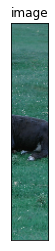

In [ ]:
sample_test_data = np.load('/content/MSRC_ObjCategImageDatabase_v1/datasets/test/1_15_s_10_.npy')
#dataX = sample_test_data[0]
#dataY = sample_test_data[1]
#print(dataY)
plot_image(sample_test_data, 'image')

Next, we define the dataset and dataloader (depends on how you define the saved rectangular patches!)

This is a dataset 

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau



is_cuda_available = torch.cuda.is_available()
if is_cuda_available:
    print("Using CUDA")
device = torch.device("cuda:0" if is_cuda_available else "cpu")
print(device)

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

class SegmentationData(data.Dataset):
    def __init__(self, data_path, csv_file, transform=None):
      # Your code 
      self.data = pd.read_csv(f'{data_path}/{csv_file}', skiprows=1, header=None)
      self.data_size = len(self.data)
      self.data_path = data_path
      self.transform = transform

            
    def __len__(self):
      # Your code 
      return self.data_size

    
    def __getitem__(self, index):
      # Your code 
      filename = self.data.iloc[index, 1]
      image_path = f'{self.data_path}/{filename}'
      image = np.load(image_path, allow_pickle=True)
      label_y = int(self.data.iloc[index, 2])

      data_y = torch.tensor(label_y)
      if self.transform:
        image = self.transform(image)

      return (image, label_y)



Using CUDA
cuda:0


## Step 2:  Now that you have dataset ready, we start to build the deep network

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [ ]:
# Simple Identity class that let's input pass without changes
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

def load_and_customize_vgg16():

  # load the pre-trained model
  vgg16 = models.vgg16(pretrained=True) 
  
  # freeze convolution weights
  for param in vgg16.features.parameters():
    param.requires_grad = False

  # customization of the last layers
  # vgg16.avgpool = Identity()
  # Add on classifier
  n_inputs = vgg16.classifier[6].in_features
  n_outputs = 10
  vgg16.classifier[6] = nn.Sequential(
                        nn.Linear(n_inputs, 256), 
                        nn.ReLU(inplace=True), 
                        nn.Dropout(0.5),
                        nn.Linear(256, n_outputs))
  
  
  return vgg16


# Model definition
class SegmentationNN(nn.Module):
    def __init__(self):  
      # Your code 
      super(SegmentationNN, self).__init__()
      
      # load the pre-trained model
      self.model = load_and_customize_vgg16()
      self.model.to(device)
      print(self.model)
      

    def forward(self, x):

      # Your code 
      # pass
      x = self.model(x)
      return x

## Step 3: 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [ ]:
import time
# Optimizer 
class Solver(object):
    def __init__(self, model, learning_rate=LEARNING_RATE):
      # Your code 
      # pass
      self.model = model
      self.criterion = nn.CrossEntropyLoss()
      self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
      # Define Scheduler
      self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.1, patience=5, verbose=True
      )
      self.epoch_acc = []
      self.epoch_loss = []
      self.running_loss = []
      self.running_acc = []

    def train(self, data_loader):
        # Your code 
        self.model.train()
        start = time.clock()
        self.epoch_acc = []
        self.epoch_loss = []
        self.running_loss = []
        self.running_acc = []

        for epoch in range(NUM_EPOCH):
          losses = []
          running_loss = 0
          running_corrects = 0
          num_samples = 0
          
          batch_loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=True)
          for idx, (image, labels) in batch_loop:

            image = image.to(device=device)
            #print(image[0].size)
            labels = labels.to(device=device)

            # forward
            predicted_labels = self.model(image)
            _, preds = torch.max(predicted_labels, 1)

            loss = self.criterion(predicted_labels, labels)

            losses.append(loss.item())

            running_corrects += torch.sum(preds == labels)
            num_samples += predicted_labels.size(0)


            # backward
            self.optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            self.optimizer.step()

            batch_loop.set_description(f'Epoch [{epoch}/{NUM_EPOCH}]')
            batch_loop.set_postfix(loss=loss.item(), acc=(running_corrects/num_samples).item())

            self.running_loss.append(sum(losses)/len(losses))
          
          avg_loss = sum(losses)/len(losses)
          avg_acc = running_corrects/num_samples
          self.scheduler.step(avg_loss)

          self.epoch_acc.append(avg_acc)
          self.epoch_loss.append(avg_loss)

          time_elapsed = time.clock() - start
          print('Epoch: [{}/{}] Time: {}min:{}sec Training Loss: {:.4f} Acc: {:.4f}'.format(epoch, NUM_EPOCH, time_elapsed//60, time_elapsed%60, avg_loss, avg_acc))


          #self.scheduler()
    
    def evaluate(self, data_loader):
        self.model.eval()

        self.epoch_acc = []
        self.epoch_loss = []
        self.running_loss = []
        self.running_acc = []
        start = time.clock()

        for epoch in range(NUM_EPOCH):
          losses = []
          running_loss = 0
          running_corrects = 0
          num_samples = 0
          
          batch_loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=True)
          with torch.no_grad():
            for idx, (image, labels) in batch_loop:
              image = image.to(device=device)
              labels = labels.to(device=device)

              # forward
              predicted_labels = self.model(image)
              _, preds = torch.max(predicted_labels, 1)

              running_corrects += torch.sum(preds == labels)
              num_samples += predicted_labels.size(0)

              batch_loop.set_description(f'Epoch [{epoch}/{NUM_EPOCH}]')
              batch_loop.set_postfix(acc=(running_corrects/num_samples).item())

          avg_acc = running_corrects/num_samples

          self.epoch_acc.append(avg_acc)

          time_elapsed = time.clock() - start
          print('Epoch: [{}/{}] Time: {}min:{}sec Training Acc: {:.4f}'.format(epoch, NUM_EPOCH, time_elapsed//60, time_elapsed%60, avg_acc))


      



## Putting it together:
Start to train your network and observe the loss in time.
During the inference stage, we combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

In [ ]:
custom_transforms = transforms.Compose([
        transforms.ToPILImage(),
        #transforms.Resize((256, 256)),
        #transforms.RandomCrop((224,224)),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])

# load the data
train_dataset = SegmentationData(train_path, TRAIN_CSVFILE, custom_transforms)
test_dataset = SegmentationData(test_path, TEST_CSVFILE, custom_transforms)


# data loader
train_data_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_data_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

dataiter = iter(train_data_loader)
data_samp = dataiter.next()
print(data_samp[0][0].shape)


torch.Size([3, 224, 224])


In [ ]:

# model
model = SegmentationNN()

# train the model
solver = Solver(model, LEARNING_RATE)

# start training 
solver.train(train_data_loader)
print('Training Done!')


#solver.test(test_data_loader)
#print('testing Done!')


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=


Epoch [0/5]: 100%|██████████| 744/744 [01:42<00:00,  7.37it/s, acc=0.82, loss=0.151]
                                                                                    

Epoch: [0/5] Time: 1.0min:21.083542999999963sec Training Loss: 0.5333 Acc: 0.8204



Epoch [1/5]: 100%|██████████| 744/744 [01:45<00:00,  7.17it/s, acc=0.923, loss=0.0256]
                                                                                      

Epoch: [1/5] Time: 2.0min:45.7584139999999sec Training Loss: 0.2179 Acc: 0.9228



Epoch [2/5]: 100%|██████████| 744/744 [01:45<00:00,  7.38it/s, acc=0.955, loss=0.00859]
                                                                                       

Epoch: [2/5] Time: 4.0min:10.054350999999997sec Training Loss: 0.1254 Acc: 0.9551



Epoch [3/5]: 100%|██████████| 744/744 [01:45<00:00,  7.43it/s, acc=0.973, loss=0.0395]
                                                                                      

Epoch: [3/5] Time: 5.0min:34.71318599999995sec Training Loss: 0.0814 Acc: 0.9735



Epoch [4/5]: 100%|██████████| 744/744 [01:45<00:00,  7.33it/s, acc=0.983, loss=0.00319]
                                                                                       

Epoch: [4/5] Time: 6.0min:59.994498999999905sec Training Loss: 0.0542 Acc: 0.9832
Training Done!


In [ ]:
torch.save(model.state_dict(), 'model_superpixel_semantic_seg_dict.pth')

In [ ]:
# model
model = SegmentationNN()

# train the model
solv = Solver(model, LEARNING_RATE)

# start training 
solv.train(train_data_loader)
print('Training Done!')


#solver.test(test_data_loader)
#print('testing Done!')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1


Epoch [0/5]: 100%|██████████| 190/190 [01:14<00:00,  2.57it/s, acc=0.8, loss=0.298]

Epoch: [0/5] Time: 1.0min:10.266696000000138sec Training Loss: 0.6074 Acc: 0.8001




Epoch [1/5]: 100%|██████████| 190/190 [01:12<00:00,  2.61it/s, acc=0.919, loss=0.263]

Epoch: [1/5] Time: 2.0min:19.746467999999822sec Training Loss: 0.2262 Acc: 0.9188




Epoch [2/5]: 100%|██████████| 190/190 [01:12<00:00,  2.61it/s, acc=0.961, loss=0.122]

Epoch: [2/5] Time: 3.0min:29.073601999999937sec Training Loss: 0.1181 Acc: 0.9612




Epoch [3/5]: 100%|██████████| 190/190 [01:12<00:00,  2.60it/s, acc=0.978, loss=0.0394]

Epoch: [3/5] Time: 4.0min:38.42238499999985sec Training Loss: 0.0640 Acc: 0.9777




Epoch [4/5]: 100%|██████████| 190/190 [01:13<00:00,  2.60it/s, acc=0.986, loss=0.0129]

Epoch: [4/5] Time: 5.0min:47.986811000000216sec Training Loss: 0.0433 Acc: 0.9863
Training Done!


In [ ]:
solv.evaluate(test_data_loader)
print('testing Done!')


Epoch [0/5]: 100%|██████████| 42/42 [00:13<00:00,  3.02it/s, acc=0.85]

Epoch: [0/5] Time: 0.0min:12.84473399999979sec Training Acc: 0.8498




Epoch [1/5]: 100%|██████████| 42/42 [00:14<00:00,  2.90it/s, acc=0.85]

Epoch: [1/5] Time: 0.0min:26.216125999999804sec Training Acc: 0.8498




Epoch [2/5]: 100%|██████████| 42/42 [00:14<00:00,  2.90it/s, acc=0.85]

Epoch: [2/5] Time: 0.0min:39.62978599999997sec Training Acc: 0.8498




Epoch [3/5]: 100%|██████████| 42/42 [00:14<00:00,  2.97it/s, acc=0.85]

Epoch: [3/5] Time: 0.0min:52.650898999999754sec Training Acc: 0.8498




Epoch [4/5]: 100%|██████████| 42/42 [00:13<00:00,  3.03it/s, acc=0.85]

Epoch: [4/5] Time: 1.0min:5.48919799999976sec Training Acc: 0.8498
testing Done!


### Inference:
Testing on a single image:

In [ ]:
def get_cropped_image(seg_map, seg_label, sample_image):
  rect_patch_loc = get_rect_patch_loc(seg_map, seg_label)
  if rect_patch_loc is not None:
    sample_im_cropped = crop_image(sample_image, rect_patch_loc)
    return sample_im_cropped
  return None
    

3_24_s.bmp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


72 Not found
73 Not found
74 Not found
75 Not found
76 Not found
77 Not found
78 Not found
79 Not found
80 Not found
81 Not found
82 Not found
83 Not found
84 Not found
85 Not found
86 Not found
87 Not found
88 Not found
89 Not found
90 Not found
91 Not found
92 Not found
93 Not found
94 Not found
95 Not found
96 Not found
97 Not found
98 Not found
99 Not found


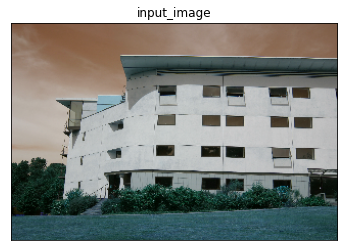

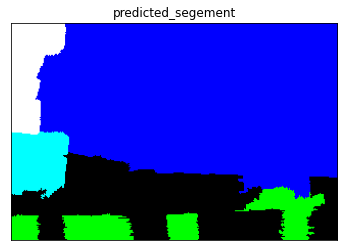

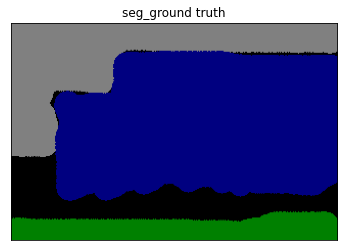

In [ ]:

## load any image from the last 20% of the list of images
list_files = os.listdir(msrc_directory)
total_images = len(list_files)
TRAIN_SIZE = int(len(list_files) * 0.8)
TEST_SIZE = total_images - TRAIN_SIZE
testing_files = list_files[TRAIN_SIZE:]

# select a random image file from the test data:
filename = testing_files[13]
i = 50
while not (BMP_EXT in filename and GT not in filename):
      i += 1
      filename = testing_files[i]

print(filename)
test_sample_filename = filename
test_gt_filename = filename.replace(BMP_EXT, (GT+BMP_EXT))

test_sample_filename = os.path.join(msrc_directory, test_sample_filename)
test_gt_filename = os.path.join(msrc_directory, test_gt_filename)

test_sample_image = cv2.imread(test_sample_filename)
test_gt_image = cv2.imread(test_gt_filename)

test_sample_image = test_sample_image[:,:,::-1]   # bgr to rgb
test_gt_image = test_gt_image[:,:,::-1]           # bgr to rgb

seg_map = slic(test_sample_image, n_segments=NUM_SLIC_SEG, compactness=10)
slic_label_to_seg_class_map = {}
predicted_seg = np.zeros(test_sample_image.shape)
model.eval()
for i in range(NUM_SLIC_SEG):
  cropped_image = get_cropped_image(seg_map, i, test_sample_image)
  if cropped_image is not None:
    ## predict_label = model.
    # forward
    cropped_image = custom_transforms(cropped_image).to(device)
    cropped_image = cropped_image.unsqueeze(0) 
    predicted_labels = model(cropped_image)

    _, preds = torch.max(predicted_labels, 1)
    slic_label_to_seg_class_map[i] = preds.item() - 1  #original labels were from -1

    ind = (seg_map == i)
    predicted_seg[ind] = label_2_rgb[preds.item()-1]
  else:
    break
    # print(i, 'Not found')
    

plot_image(test_sample_image, 'input_image')
plot_image(predicted_seg, 'predicted_segement')
plot_image(test_gt_image, 'seg_ground truth')



## Bonus Qs:
We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

In [ ]:
#TODO

# Attempted Bonus Question 2




In [ ]:
#from IPython.display import Image
#Image(filename='/ION.png') 


2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] and the following illustration figure for an example.

In [ ]:
from IPython.display import Image
Image(filename='/Multi-resolution.png') 

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features

## Improvisation: Multi-resolution implementation: Using Zoom-out features

1. Used the pre-trained VGG16 model to extract the feature maps
2. As the model is pre-trained, the feature maps were extracted before the training of the model.
3. Approach:
  - Split the MSRCv1 data into train and test
  - For each image in the training/test data:
    - Get the superpixel segmentation map using SLIC,
    - Get the upsampled feature maps by feeding the image in the VGG16 network (13 from the 13 conv layers in VGG16),
    - For the each superpixel in the segmentation map:
      - Get the corresponding region the feature maps,
      - Average pooling and converting into 1 x depth_of_ith_feature_map vector,
      - Concatenating the all the vectors to represent the feature vector of that the partiular superpixel,
      - Saving the feature vector along with the ground-truth label
  - Design a simple classifier (MLP network with hidden layers and one output layer of ten units).
  - Train the model with the feature vectors extracted from the VGGNet.

Code to extract the feature maps from individual Conv layers

In [ ]:
#TODO
'''
Code to extract the feature maps from individual Conv layers
'''

import copy


class VGGFeatures:
  def __init__(self):
    self.vgg16 = models.vgg16(pretrained=True)
    self.vgg16.to(device)
    self.vgg16.eval()
    
    # freeze convolution weights
    for param in vgg16.features.parameters():
      param.requires_grad = False

    self.transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])

    self.model_conv_layers = list(self.vgg16.children())[0]
    self.output_layers = [1,4,6,9,11,13,16,18,20,23,25,27,30] # output for the feature maps


    
  def pipe_line(self, x):
    feature_maps = []
    out_layer = 0
    scale_factor = 1
    for i, conv_layer in enumerate(self.model_conv_layers):
      with torch.no_grad():
        x = conv_layer(x)
      if i == self.output_layers[out_layer]:

        if type(conv_layer) == nn.MaxPool2d:
          scale_factor *= 2

        if scale_factor > 1:
          upsampled_x = nn.UpsamplingBilinear2d(scale_factor=scale_factor)(x)
        else:
          upsampled_x = x
        
        upsampled_x = upsampled_x.squeeze().detach().cpu().numpy()
        upsampled_x = np.einsum('ijk->jki', upsampled_x)  # channel first to channel last
        feature_maps.append(upsampled_x)
        out_layer += 1
        
    return feature_maps
  
  def get_feature_maps(self, image):
    image = self.transforms(image)
    image = image.to(device)
    image = image.unsqueeze(0)
    feature_maps = self.pipe_line(image)
    return feature_maps





In [ ]:
def extract_feature_maps(image, seg_map):
  vgg16_features = VGGFeatures()
  feature_maps = vgg16_features.get_feature_maps(image)
  return feature_maps


Code to process the feature maps

In [ ]:
'''
Code to process the feature maps, converting them into feature vectors of 
corresponding superpixels and saving them for further training.

'''

def get_gt_label(gt_image, seg_map, label):
  rect_patch_loc = get_rect_patch_loc(seg_map, label)
  gt_im_cropped = crop_image(gt_image, rect_patch_loc)
  seg_class_label = get_gt_seg_class(gt_im_cropped)
  return seg_class_label

def process_feature_maps_and_save(image, gt_image, seg_map, feature_maps, csv_objects, im_filename, data_path):
  for label in range(NUM_SLIC_SEG):
    superpixel_ind = (seg_map == label)
    if np.any(superpixel_ind):
      concat_ftr = []

      for ftr_map in feature_maps:
        #ftr_map = cv2.resize(src, seg_map.shape[:-1]) or resize the original image, gtimage and seg_map
        superpixel_features = ftr_map[superpixel_ind]
        avg_pool = superpixel_features.mean(axis=0)
        concat_ftr.extend(list(avg_pool))
      
      concat_ftr = np.array(concat_ftr)

      seg_class_label = get_gt_label(gt_image, seg_map, label)

      # save the file and the ground truth label
      data_filename = im_filename.replace(BMP_EXT, (f'_{label}_{NPY}'))
      data_filename_path = f'{data_path}/{data_filename}'
      np.save(data_filename_path, concat_ftr)

      csv_objects.append([data_filename, seg_class_label])

    else:
      # no such slic labels
      break


Data preparation for zoom-out features.

In [ ]:
'''
Preparation of data for the zoomout features:
 - For each image:
  - Get the superpixels using SLIC,
  - Get the set of feature maps,
  - Pass them to process_feature_maps_and_save() function to get feature vectors.

'''


bonus_train_dir = 'datasets/bonus_train'
bonus_test_dir = 'datasets/bonus_test'
bonus_train_path = make_dir(bonus_train_dir)
bonus_test_path = make_dir(bonus_test_dir)

def prepare_zoom_out_data(list_filenames, data_path, csv_file):
  csv_objects = []  # [image_file_path, label]
  for filename in tqdm(list_filenames, leave=True):
    # Your code
    if BMP_EXT in filename and GT not in filename:
      print(filename)
      sample_filename = filename
      gt_filename = filename.replace(BMP_EXT, (GT+BMP_EXT))
      
      sample_filename = os.path.join(msrc_directory, sample_filename)
      gt_filename = os.path.join(msrc_directory, gt_filename)

      sample_image = cv2.imread(sample_filename)
      gt_image = cv2.imread(gt_filename)
      
      sample_image = sample_image[:,:,::-1]   # bgr to rgb
      gt_image = gt_image[:,:,::-1]           # bgr to rgb

      sample_image = cv2.resize(sample_image, (224,224))
      gt_image = cv2.resize(gt_image, (224,224))

      seg_map = slic(sample_image, n_segments=NUM_SLIC_SEG, compactness=10)

      feature_maps = extract_feature_maps(sample_image, seg_map)

      process_feature_maps_and_save(sample_image, gt_image, seg_map, feature_maps, csv_objects, filename, data_path)
      
  
  # create csv file:
  imagepath_label = pd.DataFrame(csv_objects, columns=['image_feature_path', 'label'])
  imagepath_label.to_csv(f'{data_path}/{csv_file}')


prepare_zoom_out_data(training_files, bonus_train_path, TRAIN_CSVFILE)
print('Finished processing training data')

prepare_zoom_out_data(testing_files, bonus_test_path, TEST_CSVFILE)
print('Finished processing testing data')

  0%|          | 0/386 [00:00<?, ?it/s]

1_23_s.bmp


  1%|          | 3/386 [00:06<14:27,  2.27s/it]

7_27_s.bmp


  2%|▏         | 8/386 [00:12<12:15,  1.95s/it]

4_27_s.bmp


  2%|▏         | 9/386 [00:18<20:05,  3.20s/it]

2_7_s.bmp


  3%|▎         | 12/386 [00:23<16:40,  2.67s/it]

3_4_s.bmp


  4%|▎         | 14/386 [00:28<16:43,  2.70s/it]

4_19_s.bmp


  4%|▍         | 16/386 [00:34<16:52,  2.74s/it]

6_20_s.bmp


  5%|▍         | 19/386 [00:39<14:51,  2.43s/it]

2_12_s.bmp


  6%|▌         | 24/386 [00:43<11:47,  1.95s/it]

6_8_s.bmp


  7%|▋         | 27/386 [00:48<11:15,  1.88s/it]

1_25_s.bmp


  7%|▋         | 28/386 [00:54<17:25,  2.92s/it]

3_14_s.bmp


  8%|▊         | 29/386 [00:59<21:51,  3.67s/it]

2_6_s.bmp


  8%|▊         | 30/386 [01:04<24:10,  4.07s/it]

8_24_s.bmp


  8%|▊         | 31/386 [01:09<25:38,  4.33s/it]

2_10_s.bmp


  8%|▊         | 32/386 [01:14<26:05,  4.42s/it]

1_28_s.bmp


  9%|▊         | 33/386 [01:19<27:38,  4.70s/it]

1_16_s.bmp


  9%|▉         | 34/386 [01:25<29:19,  5.00s/it]

7_14_s.bmp


  9%|▉         | 35/386 [01:31<30:54,  5.28s/it]

6_5_s.bmp


 10%|█         | 40/386 [01:36<23:12,  4.02s/it]

6_12_s.bmp


 11%|█         | 42/386 [01:42<20:48,  3.63s/it]

6_11_s.bmp


 11%|█         | 43/386 [01:47<24:04,  4.21s/it]

1_7_s.bmp


 11%|█▏        | 44/386 [01:53<26:03,  4.57s/it]

4_2_s.bmp


 12%|█▏        | 45/386 [01:58<27:07,  4.77s/it]

6_15_s.bmp


 12%|█▏        | 48/386 [02:03<21:28,  3.81s/it]

7_26_s.bmp


 13%|█▎        | 50/386 [02:08<19:19,  3.45s/it]

1_3_s.bmp


 13%|█▎        | 51/386 [02:13<21:57,  3.93s/it]

2_13_s.bmp


 14%|█▍        | 54/386 [02:18<18:05,  3.27s/it]

3_10_s.bmp


 14%|█▍        | 55/386 [02:23<21:21,  3.87s/it]

1_29_s.bmp


 15%|█▍        | 57/386 [02:28<19:06,  3.48s/it]

3_5_s.bmp


 15%|█▌        | 59/386 [02:34<17:24,  3.19s/it]

8_19_s.bmp


 16%|█▌        | 60/386 [02:38<19:27,  3.58s/it]

4_9_s.bmp


 16%|█▌        | 62/386 [02:44<18:01,  3.34s/it]

3_18_s.bmp


 17%|█▋        | 65/386 [02:49<15:22,  2.87s/it]

7_21_s.bmp


 17%|█▋        | 66/386 [02:55<19:58,  3.75s/it]

5_30_s.bmp


 18%|█▊        | 68/386 [03:00<18:02,  3.40s/it]

1_12_s.bmp


 18%|█▊        | 69/386 [03:05<20:37,  3.91s/it]

2_15_s.bmp


 18%|█▊        | 71/386 [03:10<17:58,  3.43s/it]

6_29_s.bmp


 20%|█▉        | 76/386 [03:15<14:05,  2.73s/it]

5_27_s.bmp


 21%|██        | 81/386 [03:20<11:18,  2.22s/it]

2_8_s.bmp


 22%|██▏       | 83/386 [03:25<11:29,  2.28s/it]

7_20_s.bmp


 22%|██▏       | 84/386 [03:30<15:54,  3.16s/it]

7_15_s.bmp


 22%|██▏       | 86/386 [03:36<15:09,  3.03s/it]

1_17_s.bmp


 23%|██▎       | 88/386 [03:41<14:36,  2.94s/it]

8_1_s.bmp


 23%|██▎       | 89/386 [03:46<17:42,  3.58s/it]

4_3_s.bmp


 24%|██▎       | 91/386 [03:52<16:16,  3.31s/it]

7_29_s.bmp


 24%|██▍       | 94/386 [03:57<13:53,  2.85s/it]

7_16_s.bmp


 25%|██▌       | 98/386 [04:02<11:32,  2.40s/it]

5_22_s.bmp


 26%|██▌       | 99/386 [04:08<16:01,  3.35s/it]

6_14_s.bmp


 26%|██▌       | 101/386 [04:14<15:03,  3.17s/it]

3_26_s.bmp


 27%|██▋       | 103/386 [04:19<14:00,  2.97s/it]

7_23_s.bmp


 27%|██▋       | 104/386 [04:24<16:54,  3.60s/it]

6_19_s.bmp


 28%|██▊       | 110/386 [04:28<12:40,  2.75s/it]

7_4_s.bmp


 29%|██▉       | 111/386 [04:33<15:57,  3.48s/it]

1_20_s.bmp


 29%|██▉       | 112/386 [04:39<18:35,  4.07s/it]

1_26_s.bmp


 30%|██▉       | 114/386 [04:43<15:59,  3.53s/it]

5_5_s.bmp


 30%|███       | 116/386 [04:49<14:44,  3.28s/it]

4_5_s.bmp


 31%|███       | 119/386 [04:54<12:40,  2.85s/it]

7_10_s.bmp


 31%|███       | 120/386 [05:00<16:14,  3.66s/it]

4_24_s.bmp


 32%|███▏      | 123/386 [05:05<13:39,  3.11s/it]

1_30_s.bmp


 32%|███▏      | 124/386 [05:11<16:11,  3.71s/it]

5_12_s.bmp


 34%|███▎      | 130/386 [05:16<12:11,  2.86s/it]

6_10_s.bmp


 34%|███▍      | 131/386 [05:21<15:24,  3.62s/it]

3_17_s.bmp


 34%|███▍      | 132/386 [05:26<17:16,  4.08s/it]

4_8_s.bmp


 35%|███▍      | 135/386 [05:32<14:14,  3.40s/it]

6_24_s.bmp


 35%|███▌      | 136/386 [05:37<16:39,  4.00s/it]

4_20_s.bmp


 35%|███▌      | 137/386 [05:43<18:38,  4.49s/it]

8_25_s.bmp


 36%|███▌      | 138/386 [05:48<18:55,  4.58s/it]

2_29_s.bmp


 36%|███▌      | 139/386 [05:52<19:06,  4.64s/it]

5_17_s.bmp


 36%|███▋      | 140/386 [05:58<19:54,  4.86s/it]

6_22_s.bmp


 37%|███▋      | 141/386 [06:03<20:02,  4.91s/it]

8_14_s.bmp


 38%|███▊      | 145/386 [06:07<15:06,  3.76s/it]

3_15_s.bmp


 38%|███▊      | 146/386 [06:12<16:57,  4.24s/it]

2_21_s.bmp


 38%|███▊      | 147/386 [06:17<17:42,  4.45s/it]

7_6_s.bmp


 39%|███▉      | 150/386 [06:22<14:11,  3.61s/it]

6_3_s.bmp


 40%|████      | 155/386 [06:28<11:00,  2.86s/it]

7_1_s.bmp


 41%|████      | 157/386 [06:34<10:50,  2.84s/it]

1_8_s.bmp


 41%|████      | 159/386 [06:39<10:34,  2.80s/it]

4_17_s.bmp


 42%|████▏     | 161/386 [06:45<10:36,  2.83s/it]

3_16_s.bmp


 42%|████▏     | 162/386 [06:50<13:14,  3.55s/it]

2_9_s.bmp


 42%|████▏     | 163/386 [06:55<14:34,  3.92s/it]

7_18_s.bmp


 43%|████▎     | 165/386 [07:00<13:03,  3.55s/it]

7_22_s.bmp


 43%|████▎     | 166/386 [07:06<15:10,  4.14s/it]

5_29_s.bmp


 44%|████▍     | 170/386 [07:11<11:53,  3.30s/it]

1_5_s.bmp


 45%|████▍     | 172/386 [07:17<11:17,  3.16s/it]

3_25_s.bmp


 45%|████▍     | 173/386 [07:22<13:21,  3.76s/it]

1_21_s.bmp


 45%|████▌     | 175/386 [07:27<11:57,  3.40s/it]

2_1_s.bmp


 46%|████▌     | 177/386 [07:32<10:56,  3.14s/it]

4_14_s.bmp


 47%|████▋     | 180/386 [07:37<09:23,  2.73s/it]

8_3_s.bmp


 47%|████▋     | 182/386 [07:42<08:47,  2.59s/it]

6_4_s.bmp


 47%|████▋     | 183/386 [07:48<11:54,  3.52s/it]

4_4_s.bmp


 48%|████▊     | 184/386 [07:53<13:30,  4.01s/it]

1_19_s.bmp


 48%|████▊     | 185/386 [07:58<14:59,  4.48s/it]

1_14_s.bmp


 48%|████▊     | 186/386 [08:04<15:51,  4.76s/it]

3_30_s.bmp


 49%|████▉     | 189/386 [08:08<12:26,  3.79s/it]

3_13_s.bmp


 49%|████▉     | 191/386 [08:14<11:16,  3.47s/it]

8_22_s.bmp


 50%|████▉     | 192/386 [08:19<13:01,  4.03s/it]

3_8_s.bmp


 51%|█████     | 195/386 [08:24<10:28,  3.29s/it]

3_22_s.bmp


 51%|█████     | 196/386 [08:29<12:42,  4.02s/it]

8_18_s.bmp


 51%|█████     | 197/386 [08:34<13:33,  4.31s/it]

5_21_s.bmp


 52%|█████▏    | 202/386 [08:40<10:18,  3.36s/it]

3_9_s.bmp


 53%|█████▎    | 203/386 [08:46<11:58,  3.93s/it]

4_23_s.bmp


 53%|█████▎    | 206/386 [08:51<10:01,  3.34s/it]

2_4_s.bmp


 54%|█████▍    | 209/386 [08:57<08:25,  2.85s/it]

8_16_s.bmp


 54%|█████▍    | 210/386 [09:01<10:06,  3.45s/it]

5_23_s.bmp


 55%|█████▍    | 211/386 [09:07<11:58,  4.10s/it]

1_18_s.bmp


 55%|█████▍    | 212/386 [09:13<13:16,  4.58s/it]

3_11_s.bmp


 55%|█████▌    | 213/386 [09:18<14:02,  4.87s/it]

4_28_s.bmp


 56%|█████▌    | 215/386 [09:24<12:01,  4.22s/it]

5_2_s.bmp


 56%|█████▌    | 216/386 [09:29<13:00,  4.59s/it]

5_4_s.bmp


 57%|█████▋    | 221/386 [09:35<09:44,  3.54s/it]

3_12_s.bmp


 58%|█████▊    | 223/386 [09:40<08:57,  3.30s/it]

5_10_s.bmp


 58%|█████▊    | 225/386 [09:45<08:13,  3.06s/it]

5_24_s.bmp


 60%|█████▉    | 230/386 [09:51<06:25,  2.47s/it]

5_7_s.bmp


 61%|██████▏   | 237/386 [09:56<04:53,  1.97s/it]

6_9_s.bmp


 62%|██████▏   | 238/386 [10:02<07:22,  2.99s/it]

5_19_s.bmp


 62%|██████▏   | 239/386 [10:07<09:13,  3.76s/it]

7_17_s.bmp


 63%|██████▎   | 245/386 [10:13<06:51,  2.92s/it]

8_23_s.bmp


 64%|██████▎   | 246/386 [10:18<08:06,  3.48s/it]

8_12_s.bmp


 64%|██████▍   | 248/386 [10:23<07:21,  3.20s/it]

5_25_s.bmp


 65%|██████▍   | 249/386 [10:28<08:52,  3.89s/it]

4_6_s.bmp


 65%|██████▍   | 250/386 [10:33<09:47,  4.32s/it]

7_11_s.bmp


 66%|██████▌   | 254/386 [10:39<07:37,  3.47s/it]

2_20_s.bmp


 66%|██████▋   | 256/386 [10:45<06:59,  3.23s/it]

8_6_s.bmp


 67%|██████▋   | 257/386 [10:50<08:05,  3.76s/it]

1_4_s.bmp


 67%|██████▋   | 260/386 [10:55<06:39,  3.17s/it]

8_4_s.bmp


 68%|██████▊   | 263/386 [10:59<05:19,  2.60s/it]

7_2_s.bmp


 68%|██████▊   | 264/386 [11:05<07:08,  3.51s/it]

2_18_s.bmp


 69%|██████▉   | 266/386 [11:09<06:23,  3.19s/it]

2_19_s.bmp


 69%|██████▉   | 267/386 [11:14<07:16,  3.67s/it]

1_15_s.bmp


 69%|██████▉   | 268/386 [11:20<08:25,  4.29s/it]

3_29_s.bmp


 70%|██████▉   | 269/386 [11:25<08:57,  4.59s/it]

3_7_s.bmp


 70%|███████   | 272/386 [11:31<07:11,  3.78s/it]

2_14_s.bmp


 71%|███████   | 274/386 [11:36<06:23,  3.42s/it]

1_2_s.bmp


 71%|███████   | 275/386 [11:40<06:45,  3.65s/it]

7_24_s.bmp


 72%|███████▏  | 276/386 [11:46<07:51,  4.29s/it]

6_1_s.bmp


 72%|███████▏  | 278/386 [11:51<06:46,  3.76s/it]

4_29_s.bmp


 72%|███████▏  | 279/386 [11:57<07:45,  4.35s/it]

7_19_s.bmp


 73%|███████▎  | 283/386 [12:02<05:54,  3.44s/it]

6_13_s.bmp


 74%|███████▍  | 285/386 [12:08<05:25,  3.22s/it]

8_15_s.bmp


 74%|███████▍  | 286/386 [12:12<06:10,  3.71s/it]

5_26_s.bmp


 74%|███████▍  | 287/386 [12:18<07:08,  4.33s/it]

8_30_s.bmp


 75%|███████▍  | 288/386 [12:23<07:13,  4.43s/it]

1_22_s.bmp


 76%|███████▌  | 293/386 [12:28<05:18,  3.43s/it]

1_11_s.bmp


 76%|███████▌  | 294/386 [12:34<06:06,  3.99s/it]

4_22_s.bmp


 77%|███████▋  | 297/386 [12:39<04:57,  3.34s/it]

8_10_s.bmp


 77%|███████▋  | 299/386 [12:44<04:29,  3.10s/it]

3_24_s.bmp


 78%|███████▊  | 300/386 [12:50<05:36,  3.91s/it]

6_21_s.bmp


 78%|███████▊  | 301/386 [12:56<06:25,  4.54s/it]

2_25_s.bmp


 79%|███████▉  | 304/386 [13:01<05:02,  3.69s/it]

6_26_s.bmp


 79%|███████▉  | 305/386 [13:07<05:41,  4.21s/it]

2_26_s.bmp


 80%|███████▉  | 307/386 [13:11<04:50,  3.68s/it]

8_7_s.bmp


 80%|███████▉  | 308/386 [13:16<05:17,  4.07s/it]

7_8_s.bmp


 80%|████████  | 310/386 [13:22<04:40,  3.69s/it]

7_25_s.bmp


 81%|████████  | 311/386 [13:28<05:20,  4.28s/it]

4_21_s.bmp


 81%|████████▏ | 314/386 [13:33<04:16,  3.57s/it]

6_18_s.bmp


 82%|████████▏ | 316/386 [13:39<03:53,  3.33s/it]

6_2_s.bmp


 82%|████████▏ | 317/386 [13:44<04:28,  3.90s/it]

8_2_s.bmp


 82%|████████▏ | 318/386 [13:49<04:46,  4.22s/it]

2_23_s.bmp


 83%|████████▎ | 319/386 [13:54<04:51,  4.35s/it]

6_30_s.bmp


 83%|████████▎ | 322/386 [13:59<03:48,  3.58s/it]

8_26_s.bmp


 85%|████████▍ | 327/386 [14:04<02:45,  2.80s/it]

5_8_s.bmp


 85%|████████▍ | 328/386 [14:09<03:26,  3.56s/it]

2_11_s.bmp


 85%|████████▌ | 330/386 [14:14<02:56,  3.15s/it]

3_21_s.bmp


 86%|████████▌ | 331/386 [14:19<03:27,  3.78s/it]

4_16_s.bmp


 86%|████████▌ | 332/386 [14:24<03:50,  4.26s/it]

2_16_s.bmp


 86%|████████▋ | 333/386 [14:29<03:48,  4.31s/it]

6_25_s.bmp


 87%|████████▋ | 334/386 [14:35<04:08,  4.77s/it]

1_10_s.bmp


 87%|████████▋ | 335/386 [14:40<04:15,  5.01s/it]

6_7_s.bmp


 87%|████████▋ | 336/386 [14:45<04:14,  5.09s/it]

7_5_s.bmp


 88%|████████▊ | 338/386 [14:51<03:31,  4.40s/it]

4_18_s.bmp


 88%|████████▊ | 339/386 [14:57<03:43,  4.75s/it]

4_13_s.bmp


 88%|████████▊ | 340/386 [15:02<03:47,  4.94s/it]

5_6_s.bmp


 88%|████████▊ | 341/386 [15:08<03:50,  5.12s/it]

1_6_s.bmp


 89%|████████▊ | 342/386 [15:13<03:49,  5.21s/it]

5_18_s.bmp


 89%|████████▉ | 343/386 [15:18<03:45,  5.24s/it]

8_17_s.bmp


 89%|████████▉ | 345/386 [15:23<02:58,  4.34s/it]

4_11_s.bmp


 90%|████████▉ | 346/386 [15:28<03:06,  4.67s/it]

1_24_s.bmp


 90%|█████████ | 348/386 [15:33<02:32,  4.02s/it]

2_28_s.bmp


 90%|█████████ | 349/386 [15:38<02:34,  4.18s/it]

7_30_s.bmp


 91%|█████████ | 351/386 [15:43<02:11,  3.75s/it]

6_6_s.bmp


 91%|█████████ | 352/386 [15:48<02:22,  4.20s/it]

1_13_s.bmp


 91%|█████████▏| 353/386 [15:54<02:30,  4.55s/it]

3_27_s.bmp


 92%|█████████▏| 355/386 [15:59<02:01,  3.92s/it]

6_17_s.bmp


 92%|█████████▏| 356/386 [16:04<02:10,  4.35s/it]

4_30_s.bmp


 92%|█████████▏| 357/386 [16:10<02:15,  4.68s/it]

5_28_s.bmp


 93%|█████████▎| 358/386 [16:15<02:17,  4.92s/it]

8_21_s.bmp


 93%|█████████▎| 360/386 [16:19<01:46,  4.09s/it]

7_28_s.bmp


 94%|█████████▍| 362/386 [16:25<01:27,  3.65s/it]

5_11_s.bmp


 94%|█████████▍| 364/386 [16:30<01:13,  3.35s/it]

5_15_s.bmp


 95%|█████████▍| 365/386 [16:35<01:23,  3.99s/it]

8_11_s.bmp


 96%|█████████▌| 370/386 [16:40<00:49,  3.10s/it]

2_5_s.bmp


 97%|█████████▋| 376/386 [16:46<00:24,  2.43s/it]

4_7_s.bmp


 98%|█████████▊| 377/386 [16:51<00:30,  3.40s/it]

5_16_s.bmp


 98%|█████████▊| 378/386 [16:56<00:31,  3.94s/it]

4_1_s.bmp


 98%|█████████▊| 379/386 [17:02<00:30,  4.38s/it]

3_23_s.bmp


 99%|█████████▉| 382/386 [17:07<00:14,  3.58s/it]

8_9_s.bmp


  0%|          | 0/97 [00:00<?, ?it/s]

Finished processing training data
1_1_s.bmp


  3%|▎         | 3/97 [00:05<02:45,  1.76s/it]

5_9_s.bmp


  5%|▌         | 5/97 [00:10<03:03,  1.99s/it]

8_27_s.bmp


  6%|▌         | 6/97 [00:15<04:24,  2.90s/it]

6_28_s.bmp


  8%|▊         | 8/97 [00:20<04:12,  2.84s/it]

3_20_s.bmp


 10%|█         | 10/97 [00:26<04:04,  2.81s/it]

2_27_s.bmp


 13%|█▎        | 13/97 [00:30<03:22,  2.41s/it]

8_29_s.bmp


 15%|█▌        | 15/97 [00:34<03:11,  2.33s/it]

2_30_s.bmp


 19%|█▊        | 18/97 [00:39<02:47,  2.13s/it]

2_17_s.bmp


 20%|█▉        | 19/97 [00:44<03:49,  2.95s/it]

2_24_s.bmp


 24%|██▎       | 23/97 [00:49<02:58,  2.42s/it]

3_6_s.bmp


 25%|██▍       | 24/97 [00:54<04:01,  3.31s/it]

2_2_s.bmp


 26%|██▌       | 25/97 [00:59<04:32,  3.78s/it]

2_22_s.bmp


 27%|██▋       | 26/97 [01:04<04:56,  4.18s/it]

6_27_s.bmp


 28%|██▊       | 27/97 [01:10<05:23,  4.62s/it]

1_9_s.bmp


 31%|███       | 30/97 [01:15<04:13,  3.78s/it]

3_19_s.bmp


 32%|███▏      | 31/97 [01:21<04:37,  4.21s/it]

5_13_s.bmp


 34%|███▍      | 33/97 [01:26<03:56,  3.69s/it]

4_26_s.bmp


 36%|███▌      | 35/97 [01:31<03:32,  3.42s/it]

3_3_s.bmp


 37%|███▋      | 36/97 [01:37<04:10,  4.10s/it]

7_12_s.bmp


 40%|████      | 39/97 [01:43<03:20,  3.45s/it]

4_25_s.bmp


 41%|████      | 40/97 [01:48<03:54,  4.11s/it]

8_8_s.bmp


 43%|████▎     | 42/97 [01:53<03:18,  3.61s/it]

8_20_s.bmp


 45%|████▌     | 44/97 [01:58<02:50,  3.22s/it]

7_9_s.bmp


 47%|████▋     | 46/97 [02:03<02:36,  3.07s/it]

5_14_s.bmp


 53%|█████▎    | 51/97 [02:09<01:54,  2.49s/it]

4_12_s.bmp


 54%|█████▎    | 52/97 [02:14<02:30,  3.35s/it]

3_1_s.bmp


 55%|█████▍    | 53/97 [02:19<02:48,  3.84s/it]

3_2_s.bmp


 60%|█████▉    | 58/97 [02:25<01:57,  3.00s/it]

8_13_s.bmp


 62%|██████▏   | 60/97 [02:29<01:43,  2.80s/it]

8_5_s.bmp


 66%|██████▌   | 64/97 [02:34<01:16,  2.32s/it]

7_7_s.bmp


 69%|██████▉   | 67/97 [02:39<01:03,  2.13s/it]

4_10_s.bmp


 70%|███████   | 68/97 [02:44<01:29,  3.10s/it]

6_23_s.bmp


 71%|███████   | 69/97 [02:50<01:44,  3.73s/it]

4_15_s.bmp


 72%|███████▏  | 70/97 [02:55<01:55,  4.26s/it]

7_3_s.bmp


 73%|███████▎  | 71/97 [03:01<02:01,  4.67s/it]

6_16_s.bmp


 75%|███████▌  | 73/97 [03:06<01:37,  4.04s/it]

5_20_s.bmp


 77%|███████▋  | 75/97 [03:11<01:20,  3.67s/it]

8_28_s.bmp


 86%|████████▌ | 83/97 [03:17<00:38,  2.77s/it]

1_27_s.bmp


 89%|████████▊ | 86/97 [03:22<00:26,  2.45s/it]

5_1_s.bmp


 91%|█████████ | 88/97 [03:27<00:22,  2.47s/it]

3_28_s.bmp


 92%|█████████▏| 89/97 [03:32<00:26,  3.32s/it]

7_13_s.bmp


 94%|█████████▍| 91/97 [03:38<00:18,  3.14s/it]

2_3_s.bmp


 95%|█████████▍| 92/97 [03:43<00:18,  3.78s/it]

5_3_s.bmp


100%|██████████| 97/97 [03:48<00:00,  2.36s/it]

Finished processing testing data


In [ ]:
dataCSV = pd.read_csv(f'{bonus_train_path}/{TRAIN_CSVFILE}', skiprows=1, header=None)
print(dataCSV.iloc[0][1])
datanp = np.load(f'{bonus_train_path}/{dataCSV.iloc[0][1]}')
#datanp[0]

#datanp = np.array(datanp, dtype=np.float32)
datanp.shape

1_23_s_0_.npy


(4224,)

In [ ]:
'''
Network - A MLP classifier to classify the features of the superpixels into given class-labels

'''
# Model definition
class ZoomOutClassifierNN(nn.Module):
    def __init__(self, num_inputs=4224, num_outputs=10):  
      # Your code 
      super(ZoomOutClassifierNN, self).__init__()
      
      self.model = nn.Sequential( nn.Linear(num_inputs, 1024), 
                                  nn.ReLU(inplace=True), 
                                  nn.Dropout(0.5),
                                  nn.Linear(1024, 1024), 
                                  nn.ReLU(inplace=True), 
                                  nn.Dropout(0.5),
                                  nn.Linear(1024, num_outputs)
                            )
      
      self.model.to(device)
      
    def forward(self, x):
      x = self.model(x)
      return x



In [ ]:

class ToTensor:
  def __call__(self, x):
    return torch.from_numpy(x)

# load the data
zoomout_train_dataset = SegmentationData(bonus_train_path, TRAIN_CSVFILE, ToTensor())
zoomout_test_dataset = SegmentationData(bonus_test_path, TEST_CSVFILE, ToTensor())


# data loader
BATCH_SIZE=64
zoomout_train_data_loader = data.DataLoader(dataset=zoomout_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
zoomout_test_data_loader = data.DataLoader(dataset=zoomout_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

dataiter = iter(zoomout_train_data_loader)
data_samp = dataiter.next()
print(data_samp[0][0].shape)


torch.Size([4224])


In [ ]:
# model
zoomout_model = ZoomOutClassifierNN()

# train the model
solver = Solver(zoomout_model, LEARNING_RATE)

# start training 
solver.train(zoomout_train_data_loader)
print('Training Done!')


Epoch [0/5]: 100%|██████████| 213/213 [00:09<00:00, 23.15it/s, acc=0.696, loss=0.708]

Epoch: [0/5] Time: 0.0min:2.8292059999998855sec Training Loss: 0.8840 Acc: 0.6957




Epoch [1/5]: 100%|██████████| 213/213 [00:08<00:00, 23.88it/s, acc=0.798, loss=0.656]


Epoch: [1/5] Time: 0.0min:5.567997999999989sec Training Loss: 0.5603 Acc: 0.7984



Epoch [2/5]: 100%|██████████| 213/213 [00:08<00:00, 23.71it/s, acc=0.832, loss=0.49]

Epoch: [2/5] Time: 0.0min:8.325068000000101sec Training Loss: 0.4552 Acc: 0.8318




Epoch [3/5]: 100%|██████████| 213/213 [00:09<00:00, 23.43it/s, acc=0.854, loss=0.426]

Epoch: [3/5] Time: 0.0min:11.159437999999682sec Training Loss: 0.3892 Acc: 0.8542




Epoch [4/5]: 100%|██████████| 213/213 [00:09<00:00, 23.28it/s, acc=0.876, loss=0.472]

Epoch: [4/5] Time: 0.0min:14.024712999999792sec Training Loss: 0.3408 Acc: 0.8765
Training Done!


In [ ]:
solver.evaluate(zoomout_test_data_loader)
print('Testing Done!')
zoomout_model.train()


Epoch [0/5]: 100%|██████████| 47/47 [00:01<00:00, 25.73it/s, acc=0.796]

Epoch: [0/5] Time: 0.0min:0.5587039999995795sec Training Acc: 0.7959




Epoch [1/5]: 100%|██████████| 47/47 [00:01<00:00, 24.55it/s, acc=0.796]

Epoch: [1/5] Time: 0.0min:1.1467509999997674sec Training Acc: 0.7959




Epoch [2/5]: 100%|██████████| 47/47 [00:01<00:00, 24.89it/s, acc=0.796]

Epoch: [2/5] Time: 0.0min:1.7240560000000187sec Training Acc: 0.7959




Epoch [3/5]: 100%|██████████| 47/47 [00:01<00:00, 25.64it/s, acc=0.796]

Epoch: [3/5] Time: 0.0min:2.2942299999999705sec Training Acc: 0.7959




Epoch [4/5]: 100%|██████████| 47/47 [00:01<00:00, 25.48it/s, acc=0.796]

Epoch: [4/5] Time: 0.0min:2.8676379999997152sec Training Acc: 0.7959
Testing Done!


Inferrence:
Testing on a single image:

In [ ]:
def get_feature_vec(seg_map, label, feature_maps):
  superpixel_ind = (seg_map == label)
  if np.any(superpixel_ind):
    concat_ftr = []
    for ftr_map in feature_maps:
      superpixel_features = ftr_map[superpixel_ind]
      avg_pool = superpixel_features.mean(axis=0)
      concat_ftr.extend(list(avg_pool))
    
    concat_ftr = np.array(concat_ftr)
    return concat_ftr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ZoomOutClassifierNN(
  (model): Sequential(
    (0): Linear(in_features=4224, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=10, bias=True)
  )
)

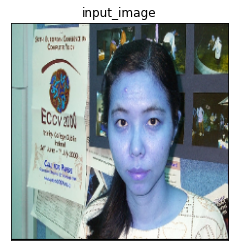

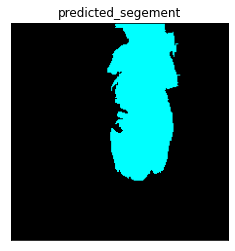

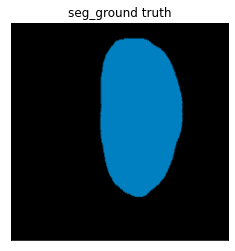

In [ ]:

## load any image from the last 20% of the list of images
'''
list_files = os.listdir(msrc_directory)
total_images = len(list_files)
TRAIN_SIZE = int(len(list_files) * 0.8)
TEST_SIZE = total_images - TRAIN_SIZE
testing_files = list_files[TRAIN_SIZE:]
'''
# select a random image file from the test data:
filename = testing_files[13]
i = 5
while not (BMP_EXT in filename and GT not in filename):
      i += 1
      filename = testing_files[i]

#print(filename)
test_sample_filename = filename
test_gt_filename = filename.replace(BMP_EXT, (GT+BMP_EXT))

test_sample_filename = os.path.join(msrc_directory, test_sample_filename)
test_gt_filename = os.path.join(msrc_directory, test_gt_filename)

test_sample_image = cv2.imread(test_sample_filename)
test_gt_image = cv2.imread(test_gt_filename)

test_sample_image = test_sample_image[:,:,::-1]   # bgr to rgb
test_gt_image = test_gt_image[:,:,::-1]           # bgr to rgb

test_sample_image = cv2.resize(test_sample_image, (224,224))
test_gt_image = cv2.resize(test_gt_image, (224,224))

seg_map = slic(test_sample_image, n_segments=NUM_SLIC_SEG, compactness=10)
feature_maps = extract_feature_maps(test_sample_image, seg_map)


slic_label_to_seg_class_map = {}

predicted_seg = np.zeros(test_sample_image.shape)
zoomout_model.eval()

for i in range(NUM_SLIC_SEG):
  feature_vector = get_feature_vec(seg_map, i, feature_maps)
  if feature_vector is not None:
    ## predict_label = model.
    # forward
    feature_vector = torch.from_numpy(feature_vector).to(device)
    feature_vector = feature_vector.unsqueeze(0) 
    predicted_labels = zoomout_model(feature_vector)

    _, preds = torch.max(predicted_labels, 1)
    slic_label_to_seg_class_map[i] = preds.item() - 1  #original labels were from -1

    ind = (seg_map == i)
    predicted_seg[ind] = label_2_rgb[preds.item()-1]
  else:
    break
    # print(i, 'Not found')
    

plot_image(test_sample_image, 'input_image')
plot_image(predicted_seg, 'predicted_segement')
plot_image(test_gt_image, 'seg_ground truth')

zoomout_model.train()